# **Sentiment Analysis with VADAR and BeautifulSoup**

Sentiment Analysis enables companies to know what kind of emotion/sentiment do customers have for them. This can play a huge role because companies can improve their products/services based on the analysis of customer sentiments.

VADER ( Valence Aware Dictionary for Sentiment Reasoning) is an open-sourced package within the Natural Language Toolkit (NLTK). VADER uses NLP algorithm that blended a sentiment lexicon approach as well as grammatical rules and syntactical conventions for expressing sentiment polarity and intensity. In this project, I will go through some technical details of using VADAR for the sentiment analysis on stock market by evaluation the news headlines. 

I will also demonstrate how to extract the financial data by using web scraping library: BeautifulSoup. The data provided by Finviz. Finviz offers free financial news and data services. 

Datasource: https://finviz.com/

In [ ]:
from bs4 import BeautifulSoup
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
from wordcloud import WordCloud

# import the Requests module so that we can collect a sample web page
from urllib.request import urlopen, Request

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:

finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['TSLA', 'NVDA', 'TWTR']

## **BeautifulSoup** 

BeautifulSoup is one of the most prolific Python libraries for web scraping. It is a lightweight, easy-to-learn, and highly effective way to programmatically isolate information on a single webpage at a time. It's common to use BeautifulSoupin conjunction with the requests library, where requests will fetch a page, and BeautifulSoup will extract the resulting data.

In [3]:
news_tables = {}
for ticker in tickers:
    url = finviz_url + ticker

    # fetch a page and send request
    req = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(req)

    # create a BeautifulSoup object from a page's HTML
    # the servers and network peers to identify 
    html = BeautifulSoup(response, features='html.parser')
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

parsed_data = []

In [4]:
for ticker, news_table in news_tables.items():
    # extract a single tag from a page 
    for row in news_table.findAll('tr'):
        # create a text row on each news headline
        title = row.a.text
        date_data = row.td.text.split(' ')
        # few headlines does not come with both date and time
        # need to separte these two kinds
        if len(date_data) == 1:
          time = date_data[0]
        else:
          date = date_data[0]
          time = date_data[1]


        parsed_data.append([ticker, date, time, title])

df = pd.DataFrame(parsed_data, columns = ['ticker', 'date', 'time', 'title'])

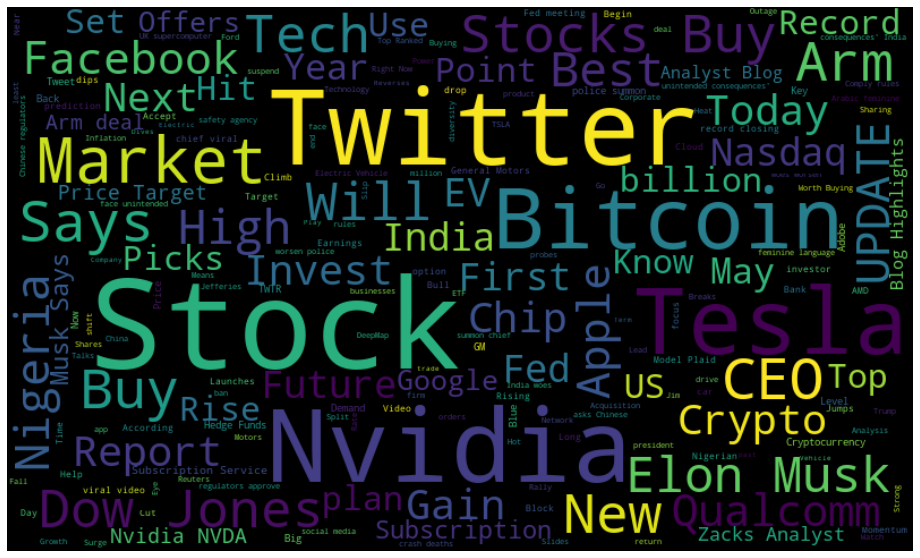

In [5]:
# Generate a word cloud image
allWords = ' '.join([txts for txts in df['title']])
wordCloud = WordCloud(width = 800, height = 480, random_state = 21, max_font_size = 110).generate(allWords)

# Display the generated image:
plt.figure(figsize = (25, 10))
plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

## **VADAR**

VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. 

It is used for sentiment analysis of text which has both the polarities i.e. positive/negative. VADER is used to quantify how much of positive or negative emotion the text has and also the intensity of emotion.

**Advantages**:

* It does not require any training data.
* It can very well understand the sentiment of a text containing emoticons, slangs, conjunctions, capital words, punctuations and much more.
* It works excellent on social media text.
* It can work with multiple domains.

**polarity_scores** 

Polarity_scores is a method which will give us scores of the following 
* categories:
* Positive
* Negative
* Neutral

**compound score** 

The compound score is the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive). The more Compound score closer to +1, the higher the positivity of the text.

In [6]:
# Create a SentimentIntensityAnalyzer object
sentiment = SentimentIntensityAnalyzer()

f = lambda title: sentiment.polarity_scores(title)['compound']
df['compound'] = df['title'].apply(f)

g = lambda c: 'pos' if c >=0 else 'neg'
df['comp_score'] = df['compound'].apply(g)
df['date'] = pd.to_datetime(df.date).dt.date

**Adding Scores and Labels to the DataFrame**

Let's add columns to the original DataFrame to store polarity_score dictionaries, extracted compound scores, and new “pos/neg” labels derived from the compound score. We’ll use this last column to perform an accuracy test. The reviews in this method will be classified into negative, positive and, neutral ratio.

In [21]:
# Create a SentimentIntensityAnalyzer object
sentiment = SentimentIntensityAnalyzer()

df['scores'] = df['title'].apply(lambda title: sentiment.polarity_scores(title))

df

,ticker,date,time,title,compound,comp_score,scores
0,TSLA,2021-06-18,05:45PM,Tesla Isnt the Only Self-Driving Car Company. ...,-0.2960,neg,"{'neg': 0.145, 'neu': 0.855, 'pos': 0.0, 'comp..."
1,TSLA,2021-06-18,04:13PM,"Why Moderna, Illumina, or Chinas Meituan Could...",0.0000,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,TSLA,2021-06-18,02:49PM,Is Ford Stock A Buy Now? Shares Pulling Back A...,0.2960,pos,"{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compou..."
3,TSLA,2021-06-18,11:50AM,"Dow Jones Dives 500 Points, Tech Stocks Cut Lo...",-0.5859,neg,"{'neg': 0.255, 'neu': 0.745, 'pos': 0.0, 'comp..."
4,TSLA,2021-06-18,10:59AM,Morning Brief: The past is outperforming the f...,0.0000,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
...,...,...,...,...,...,...,...
295,TWTR,2021-06-02,09:46AM,Twitter Launching Pilot Ad Program for Fleets,0.0000,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
296,TWTR,2021-06-02,09:03AM,Twitter Begins Testing Full Screen Vertical Fo...,0.0000,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
297,TWTR,2021-06-02,06:12AM,South Africas Eskom Extends Power Cuts as More...,-0.6682,neg,"{'neg': 0.413, 'neu': 0.483, 'pos': 0.104, 'co..."
298,TWTR,2021-06-02,05:25AM,Musk Says Panic-Buying of Chips Is Like Rush o...,0.3612,pos,"{'neg': 0.0, 'neu': 0.8, 'pos': 0.2, 'compound..."


Let's call out compound as a separate column and all values greater than zeroes will be considered a positive review and all values less than zero would be considered as a negative review.

In [20]:
df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])

df.head()

,ticker,date,time,title,compound,comp_score,scores
0,TSLA,2021-06-18,05:45PM,Tesla Isnt the Only Self-Driving Car Company. ...,-0.2960,neg,"{'neg': 0.145, 'neu': 0.855, 'pos': 0.0, 'comp..."
1,TSLA,2021-06-18,04:13PM,"Why Moderna, Illumina, or Chinas Meituan Could...",0.0000,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,TSLA,2021-06-18,02:49PM,Is Ford Stock A Buy Now? Shares Pulling Back A...,0.2960,pos,"{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compou..."
3,TSLA,2021-06-18,11:50AM,"Dow Jones Dives 500 Points, Tech Stocks Cut Lo...",-0.5859,neg,"{'neg': 0.255, 'neu': 0.745, 'pos': 0.0, 'comp..."
4,TSLA,2021-06-18,10:59AM,Morning Brief: The past is outperforming the f...,0.0000,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [23]:
df['comp_score'] = df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

df.head()

,ticker,date,time,title,compound,comp_score,scores
0,TSLA,2021-06-18,05:45PM,Tesla Isnt the Only Self-Driving Car Company. ...,-0.2960,neg,"{'neg': 0.145, 'neu': 0.855, 'pos': 0.0, 'comp..."
1,TSLA,2021-06-18,04:13PM,"Why Moderna, Illumina, or Chinas Meituan Could...",0.0000,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,TSLA,2021-06-18,02:49PM,Is Ford Stock A Buy Now? Shares Pulling Back A...,0.2960,pos,"{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compou..."
3,TSLA,2021-06-18,11:50AM,"Dow Jones Dives 500 Points, Tech Stocks Cut Lo...",-0.5859,neg,"{'neg': 0.255, 'neu': 0.745, 'pos': 0.0, 'comp..."
4,TSLA,2021-06-18,10:59AM,Morning Brief: The past is outperforming the f...,0.0000,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


Let's plot the compound scores for the stocks during the data period. The chart shows that Twitter(TWTR) received more negative sentiment throughout the period. Contrastly, Nvidia(NVDA) and Tesla (TSLA) received constant positive sentitment througout the period. 

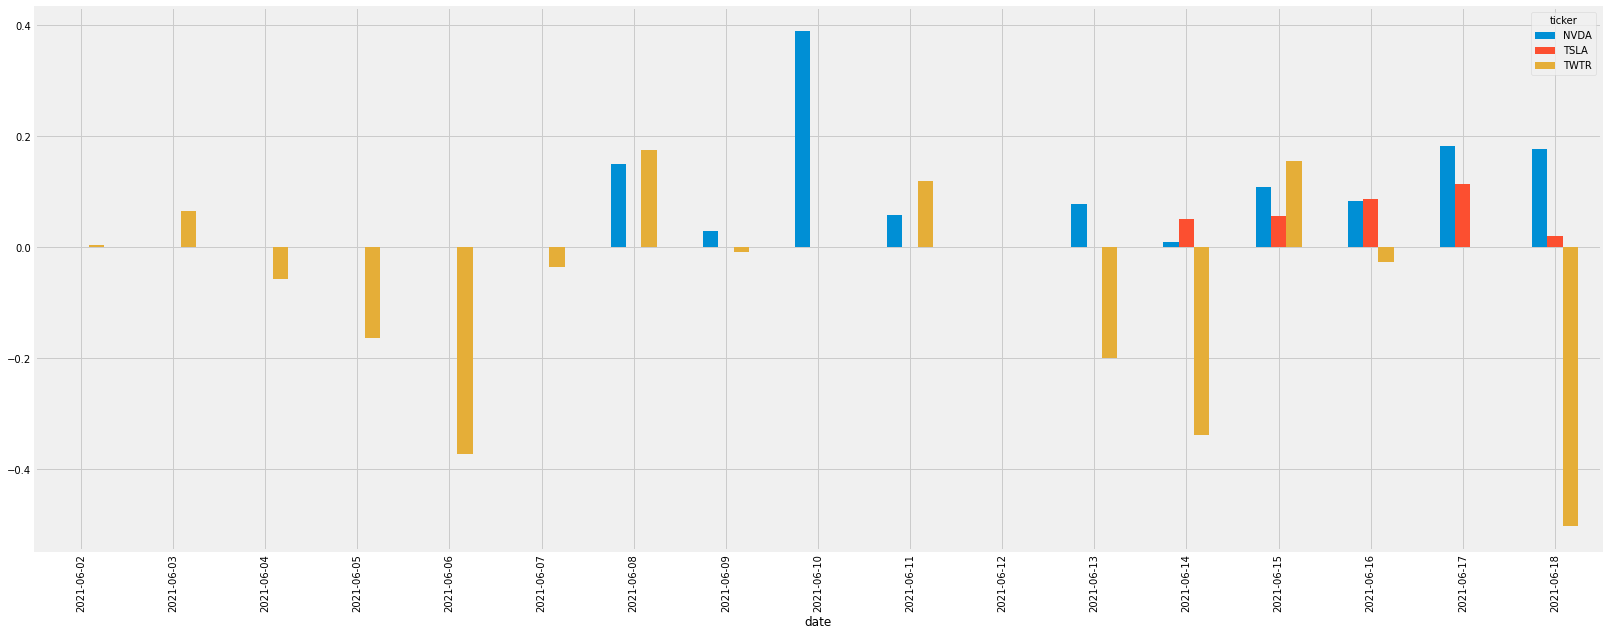

In [22]:
mean_df = df.groupby(['ticker', 'date']).mean().unstack()
mean_df = mean_df.xs('compound', axis='columns').transpose()
mean_df.plot(kind='bar', figsize=(25, 10))
plt.show()

In [26]:
! pip install finvizfinance


     |████████████████████████████████| 61kB 8.0MB/s 
     |████████████████████████████████| 256kB 19.0MB/s 


'https://finviz.com/chart.ashx?t=tsla&ty=c&ta=1&p=d'